# ARIMA на исторических

In [445]:
from alex.database import Database # вспомогательный класс для подключения к базе и работе с sql
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
import pandas as pd
from decimal import Decimal
%matplotlib inline
from pprint import pprint

In [1385]:
# stat packages
import statsmodels as sm
from statsmodels.tsa.stattools import acf # функция расчёта автокорреляций
from statsmodels.graphics.tsaplots import plot_acf # визуализация автокорреляций
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

In [443]:
import seaborn as sns 
sns.set_style("whitegrid")
import altair as alt # пакет визуализации Altair
alt.renderers.enable('notebook')
alt.data_transformers.enable('csv')

DataTransformerRegistry.enable('csv')

In [4]:
db = Database() # подключение к базе данных с учётными данными для Alex

## Загрузка истории

In [5]:
exchange = "binance"
pair = "ETH/USDT"
lag_seconds = 86400*7 #- 1 day

sql = f"select id, dt, price, amount, side from tvf_get_history_seconds_ago({lag_seconds}) order by dt, id"
history = db.query(sql)
# history = db.optimize_df(db.query(sql))

In [6]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547564 entries, 0 to 1547563
Data columns (total 5 columns):
id        1545805 non-null float64
dt        1547564 non-null datetime64[ns]
price     1547564 non-null float64
amount    1547564 non-null float64
side      1547564 non-null object
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 59.0+ MB


In [18]:
#history.index = pd.to_datetime(history['dt'])
#del history['dt']
history.set_index('dt', inplace=True)
history.side.astype('category')
history['volume'] = history.price * history.amount

### Фильтрация исходного набора

In [8]:
history_bak = history.copy()
#history = history[:int(len(history)/4)]
#history = history_bak.copy()

## Визуализация загруженных данных

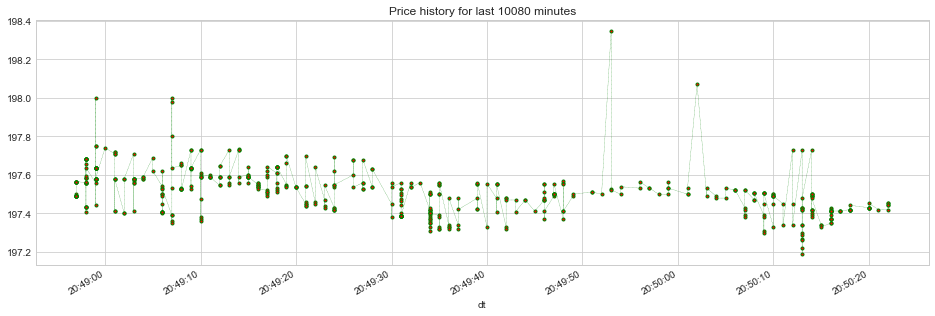

In [444]:
plt.rcParams['figure.figsize'] = [16, 5]
history['price'][-500:].plot(grid=True, marker='.', color='green', linestyle='--', 
                              linewidth=0.25, markerfacecolor='r')
plt.title(f"Price history for last {int(lag_seconds/60)} minutes")
plt.show()

## Мин, макс, среднее, медиана, стд.отклонение

In [20]:
h = history.describe()
mean = h.loc['mean', 'volume']
std = h.loc['std', 'volume']
median = h.loc['50%', 'volume']
low = h.loc['min', 'volume']
high= h.loc['max', 'volume']
print(f"среднее объёма = ${mean:.2f}\n"
      f"медиана объёма = ${median:.2f}\n"
      f"стандартное отклонение объёма = {std:.2f}\n"
      f"минимум объёма = ${low:.6f}\n"
      f"максимум объёма = ${high:.2f}")

среднее объёма = $457.16
медиана объёма = $58.81
стандартное отклонение объёма = 2467.16
минимум объёма = $0.000002
максимум объёма = $925504.71


In [21]:
h = history.describe()
mean = h.loc['mean', 'price']
std = h.loc['std', 'price']
median = h.loc['50%', 'price']
low = h.loc['min', 'price']
high= h.loc['max', 'price']
print(f"среднее цены = ${mean:.2f}\n"
      f"медиана цены = ${median:.2f}\n"
      f"стандартное отклонение цены = {std:.2f}\n"
      f"минимум цены = ${low:.6f}\n"
      f"максимум цены = ${high:.2f}")

среднее цены = $214.88
медиана цены = $224.06
стандартное отклонение цены = 13.62
минимум цены = $188.000000
максимум цены = $233.00


## Автокорреляция

In [12]:
def plot_price(x):
    plt.rcParams['figure.figsize'] = [16, 3]
    plt.plot(x[:100], marker='o', color='gray', linestyle='--', linewidth=1, markerfacecolor='r')
    plt.show()

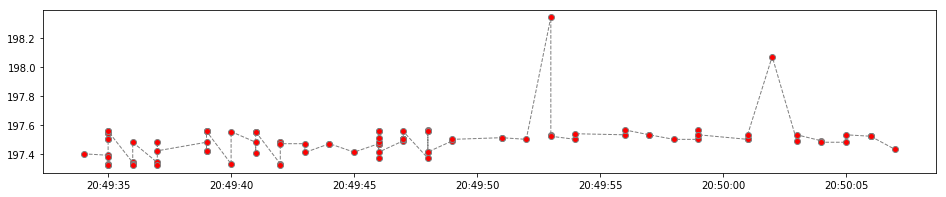

In [396]:
plot_price(history.price[-200:])

Справочно: очень высокая автокорреляция соседних абсолютных значений цены

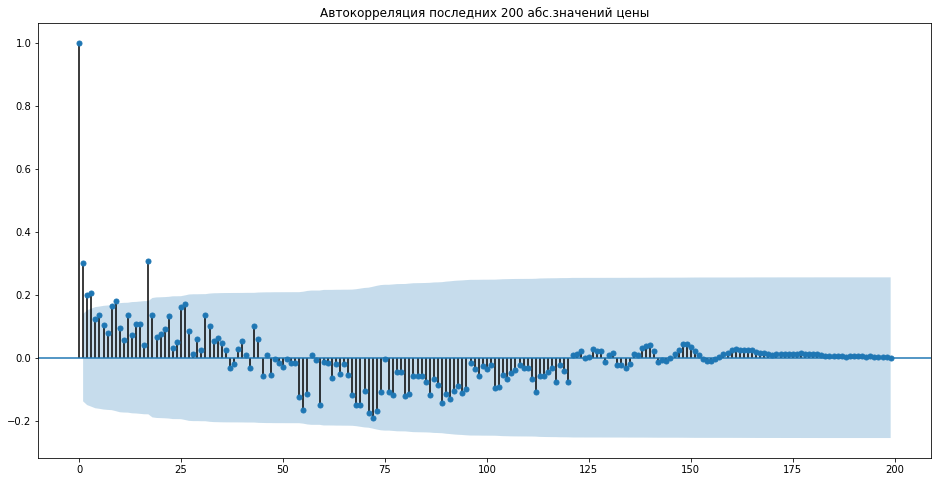

In [13]:
plt.rcParams['figure.figsize'] = [16, 8]
_ = plot_acf(history.price[-200:], title="Автокорреляция последних 200 абс.значений цены", alpha=0.05)

<b>Доверительный интервал</b> в 95% [1 - alpha] обозначен голубым конусом. Значения корреляций ВНЕ этого конуса показывают, что это не просто статистический выброс.<br/><br/>
Корелограмма медленно убывает по синусоиде, что косвенно указывает на нестационарность ряда

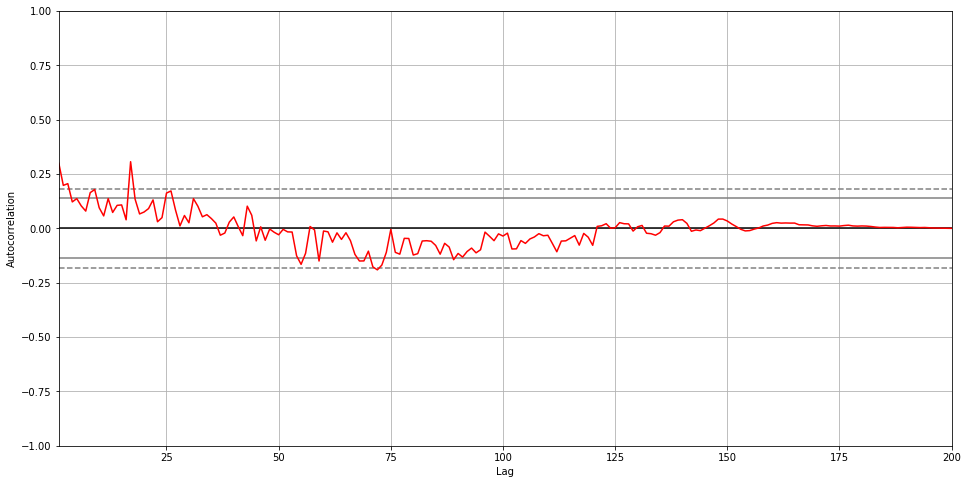

In [417]:
# второй вариант, используется встроенный в pandas autocorrelation_plot
plt.rcParams['figure.figsize'] = [16, 8]
autocorrelation_plot(history.price[-200:], color='r')
plt.show()

## Конвертация в OHLC

In [1400]:
interval = 2 # minutes
df = history[['price', 'amount']].resample(str(interval)+'min').ohlc()

In [1401]:
df.head()

price                                       amount  \
                           open        high         low       close     open   
dt                                                                             
2018-10-05 20:50:00  223.649994  223.649994  223.380005  223.436295  0.00005   
2018-10-05 20:52:00  223.369995  223.500000  223.233795  223.245407  0.25700   
2018-10-05 20:54:00  223.218506  223.481766  223.123901  223.289993  3.00000   
2018-10-05 20:56:00  223.126801  223.838745  223.050003  223.252899  0.05000   
2018-10-05 20:58:00  223.252899  223.952499  223.045303  223.226593  0.82900   

                                                    
                          high      low      close  
dt                                                  
2018-10-05 20:50:00  28.571808  0.00005   0.080000  
2018-10-05 20:52:00  92.314713  0.00001  42.060638  
2018-10-05 20:54:00  44.845852  0.00001   1.863000  
2018-10-05 20:56:00  42.960690  0.00001   0.962142  
2018-10-05 20:58:00  24.629259  0.00001   5.736000

In [1402]:
df.shape

(5041, 8)

In [1403]:
autocorrelation = df.price.close.autocorr(lag=1)
confidence = 1.96 / np.sqrt(len(df))
print(f"Автокорреляция по {interval}-минутным интервалам = {autocorrelation*100:.2f}%")
print(f"Приблизительный доверительный интервал = +/- {confidence:.4f}")

Автокорреляция по 2-минутным интервалам = 99.97%
Приблизительный доверительный интервал = +/- 0.0276


In [1404]:
autocorrelation = df.price.close.pct_change().autocorr()
confidence = 1.96 / np.sqrt(len(df))
print(f"Автокорреляция по {interval}-минутным интервалам изменения по {interval}-мин интервалу = {autocorrelation*100:.2f}%")
print(f"Приблизительный доверительный интервал = +/- {confidence:.4f}")

Автокорреляция по 2-минутным интервалам изменения по 2-мин интервалу = -0.53%
Приблизительный доверительный интервал = +/- 0.0276


## Сезонность (разные лаги)

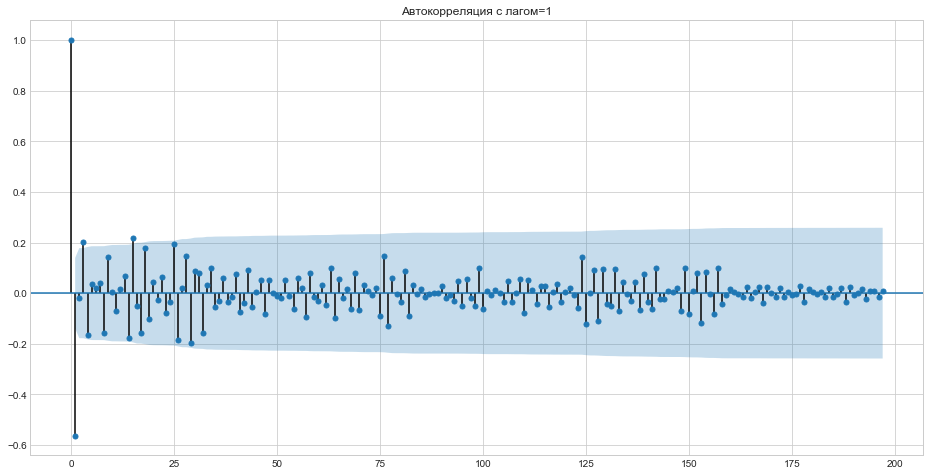

In [1405]:
lag = 1
df_lag = df.tail(200).price.close.pct_change().diff(lag).dropna()
plt.rcParams['figure.figsize'] = [16, 8]
plot_acf(df_lag, title=f"Автокорреляция с лагом={lag}")
plt.show()


## ARIMA

In [1406]:
# исходный набор, на котором тестируем ARIMA
df.price.tail()

,open,high,low,close
dt,,,,
2018-10-12 20:42:00,198.699997,198.899994,198.385605,198.428802
2018-10-12 20:44:00,198.428802,198.881973,198.399994,198.484894
2018-10-12 20:46:00,198.485001,198.881973,198.149994,198.160004
2018-10-12 20:48:00,198.199997,198.881973,197.309998,197.531494
2018-10-12 20:50:00,197.500000,198.072586,197.190002,197.442398


In [1407]:
# Примерно 10000 строк, минутная разбивка
df.price.close.describe()

count    5040.000000
mean      220.100780
std        11.749285
min       189.060593
25%       222.564495
50%       225.419998
75%       227.500000
max       231.747299
Name: close, dtype: float64

In [1408]:
# train/test split
split_point = int(1440*2/interval) # 2 days
ending = int(1440*3/interval)
train = df.fillna(method='ffill').head(split_point)
test = df.fillna(method='ffill').iloc[split_point:ending,:]

In [1409]:
df_pct = df.price.close.head(len(train)+len(test)).diff().dropna(how='all')

In [1410]:
# xticks = pd.date_range(start=train.index.min(), end=train.index.max(), freq='15min')
days = dates.DayLocator()
hours = dates.HourLocator()
dfmt = dates.DateFormatter('%H:%M')

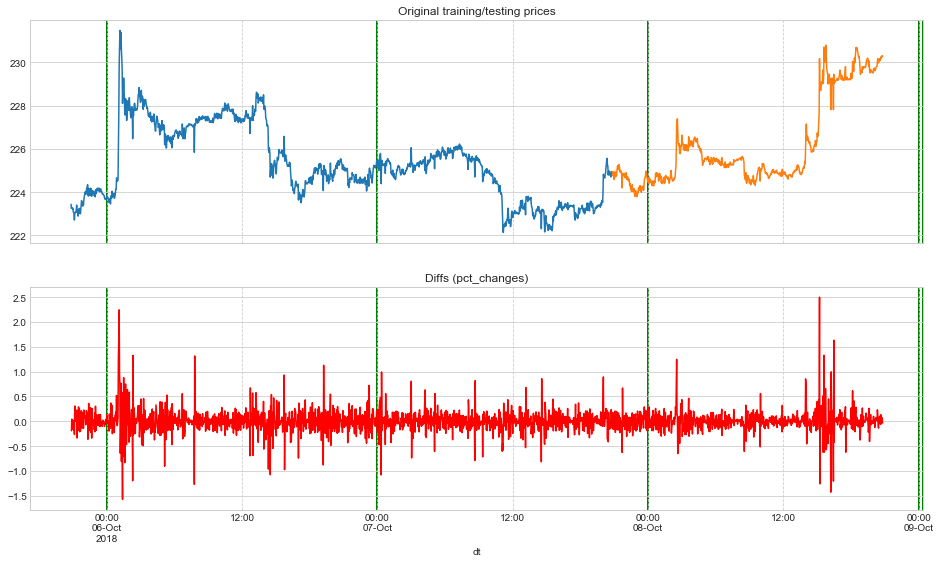

In [1411]:
plt.rcParams['figure.figsize'] = [16, 9]
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
ax0, ax1 = axes

ax0.grid(True, which='minor', linestyle='--')
ax0.grid(True, which='major', axis='x', color='g', linewidth=2)
ax1.grid(True, which='major', axis='x', color='g', linewidth=2)
ax1.xaxis.set_major_locator(days)
ax1.xaxis.set_minor_formatter(dfmt)
ax1.xaxis.set_minor_locator(hours)
ax1.grid(True, which='minor', axis='x', linestyle='--')

train.price.close.plot(ax=ax0, title="Original training/testing prices")
test.price.close.plot(ax=ax0)
df_pct.plot(ax=ax1, color='r', title="Diffs (pct_changes)")
plt.show()

In [1512]:
# ARIMA model init
p,d,q = 3,1,3
#model = ARMA(train.price.close, order=(p, q))
model = ARIMA(train.price.close, order=(p,d,q))
#model = SARIMAX(train.price.close, order=(p,d,q), trend='n', seasonal_order=(1,1,1,1), 
#                enforce_stationarity=True, enforce_invertibility=False)

In [1513]:
result = model.fit()

In [1514]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 1439
Model:                 ARIMA(3, 1, 3)   Log Likelihood                  29.567
Method:                       css-mle   S.D. of innovations              0.237
Date:                Sat, 13 Oct 2018   AIC                            -43.134
Time:                        03:10:40   BIC                             -0.960
Sample:                    10-05-2018   HQIC                           -27.390
                         - 10-07-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.004      0.178      0.859      -0.007       0.008
ar.L1.D.close    -0.1855      0.272     -0.681      0.496      -0.719       0.348
ar.L2.D.close     0.6442      0.156     

In [1515]:
start = pd.to_datetime(train.index[0]).strftime('%Y-%m-%d %H:%M:%S')
end = pd.to_datetime(train.index[-1]).strftime('%Y-%m-%d %H:%M:%S')
start, end

('2018-10-05 20:50:00', '2018-10-07 20:48:00')

In [1518]:
forecast0 = result.forecast()[0][0]
fact_price = test.price.close[0]
error = (forecast0/fact_price-1)*100
print(f"Next {interval}-min forecast: {forecast0}, actual: {fact_price}, error: {error:.2f}%")

Next 2-min forecast: 224.81841569396812, actual: 224.7808074951172, error: 0.02%


In [1519]:
# вычисляем предсказания - вычисленная линейная компонента
predictions = result.predict(start=d, end=len(train)+len(test)) #, typ='levels')
predictions[end:].head(5)

2018-10-07 20:48:00   -0.006667
2018-10-07 20:50:00    0.012309
2018-10-07 20:52:00   -0.023051
2018-10-07 20:54:00   -0.001795
2018-10-07 20:56:00   -0.008888
Freq: 2T, dtype: float64

In [1520]:
# вычисляем out-of-sample прогноз
forecasts = result.forecast(steps=len(test))

In [1522]:
forecast = pd.DataFrame(list(zip(test.price.close.index[:len(forecasts)], forecasts[0])), 
             columns=['dt', 'forecast']).set_index('dt')['forecast']
forecast.head()

dt
2018-10-07 20:50:00    224.818416
2018-10-07 20:52:00    224.795364
2018-10-07 20:54:00    224.793569
Name: forecast, dtype: float64

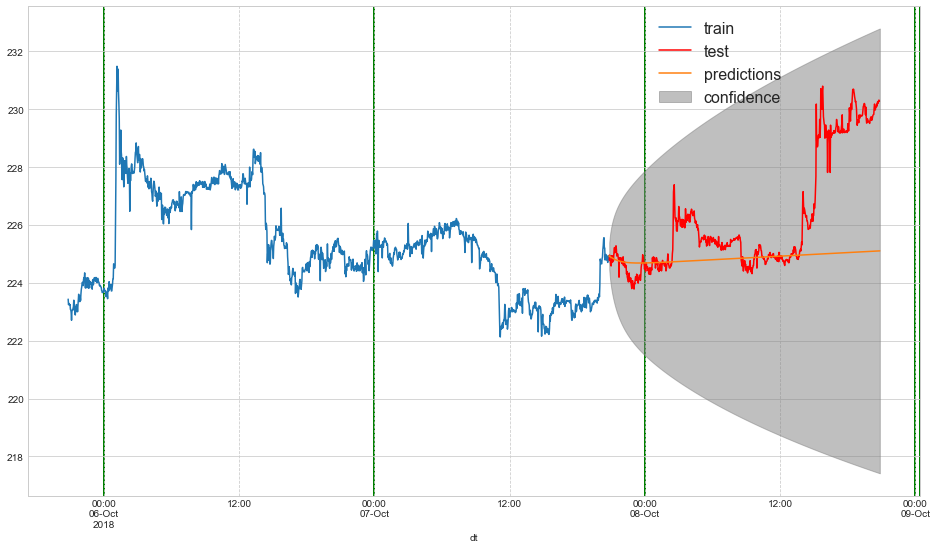

In [1530]:
fig, ax = plt.subplots()
train.price.close.plot()
test.price.close.plot(color='r')
#predictions[end:].head(500).plot(color='g', linewidth=2)
#forecast.plot(color='orange', linewidth=2)
ax.grid(True, which='minor', linestyle='--')
ax.grid(True, which='major', axis='x', color='g', linewidth=2)

fig = result.plot_predict(start=end, end=len(train)+len(test), dynamic=True, plot_insample=False, ax=ax)

ax.legend(['train', 'test', 'predictions', 'confidence'], prop={'size': 16}, loc='upper right', bbox_to_anchor=(0.86, 1))
plt.show()